**Solving Sudoku Puzzle Using Neural Network**

The **classic sudoku** is a number placing puzzle game with a grid of **9 rows and 9 columns**, partly filled with **numbers 1..9** . We have to fill up the remaining positions such that each **row, columns and 3x3 sub grids** contains numbers 1..9, **without repeatation**.

Here our **input** is an **image of sudoku** puzzle and we need to produce a corresponding **output image** by filling the remaining positions of the input. The pipeline for the **solution** consists of the following steps.

1. Preprocess the input image and remove the background
2. Crop subregions containing digits from the grid
3. Predict numbers from image crops using neural network
4. Predict solution using neural network in an iterative manner
5. Verify the solution and plot the resuts on the input image

![picture](https://drive.google.com/uc?export=view&id=1VnRccmRBtTRFhk3Oq5ThfZbJQ92RYAkB)

Initially **download** the sample images and tf.keras models for **digit recognition** and **sudoku solving**.

In [ ]:
!wget "https://www.dropbox.com/s/0cp4cyrtsphrpz4/data.zip"
!unzip data.zip

**Preprocess And Remove Background**

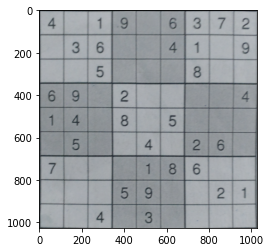

In [8]:
import cv2
import numpy as np
import math
import os

import matplotlib.pyplot as plt
from skimage.util import view_as_blocks
from tensorflow.keras.models import load_model

# Read input sudoku image 
img =  cv2.imread("images/sudoku_star1.jpg")

# Preprocess the input image
img = cv2.resize(img,(1026,1026))
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = cv2.adaptiveThreshold(imgray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,21,21)

# Find the largest contour and approximate the polygonal curve
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnt = max(contours, key = cv2.contourArea)
epsilon = 0.1*cv2.arcLength(cnt,True)
cnt = cv2.approxPolyDP(cnt,epsilon,True).squeeze()

# Sort co-ordinates in top-left raster order
cor_list=cnt.tolist()
ord_list=sorted(cor_list[:2])+sorted(cor_list[2:]) 

# Apply perspective transformation and get the  warped image
pts1 = np.float32(ord_list) #raster 
pts2 = np.float32([[0,0],[1026,0],[0,1026],[1026,1026]])
M = cv2.getPerspectiveTransform(pts1,pts2)
out_gry = cv2.warpPerspective(img,M,(1026,1026))
out_bin = cv2.warpPerspective(thresh,M,(1026,1026))

# Save the binary and grayscale outputs
cv2.imwrite('puzzle.jpg', out_gry)
cv2.imwrite('puzzle_bin.jpg', out_bin)

# Show the grayscale output image
plt.imshow(out_gry)

**Crop ROI Blocks**

Here, we use the previous **binarized** version of **output image**  for further processing.

* Divide the image into **9 rows and 9 columns** roughly along the grid patterns in the original image, such that each **block** containig the digits have **same sizes**.
* For each such block in the image we **crop the ROI**(81x81) containing the digits(or blank) from center. The croppred regions are **dilated** using morphological transformations and **resized** to **32x32** size.
* If the ROI regions are **blank spaces** representing unfilled positions, we replace them with a **template** image of digit **zero**. 

Finally, save these entire batch of images as a **float numpy array**, in order and **plot** the results.

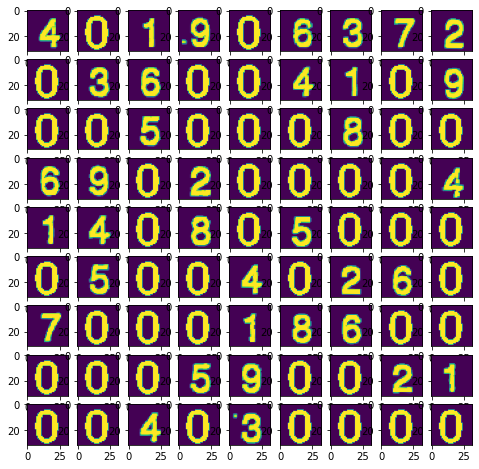

In [9]:
# Crop square ROI from the center of image
def crop_center(img,cropx,cropy):
    
    y,x = img.shape[0],img.shape[1]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    
    return img[starty:starty+cropy,startx:startx+cropx]

# Dilate the image and resize to 32x32 resolution
def dilate_resize(img):
  
  kernel = np.ones((6,6),np.uint8)
  
  img=cv2.dilate(img,kernel,iterations = 1)
  img=cv2.resize(img,(32,32),cv2.INTER_AREA)
  
  return img

# Fill the blank regions with image of zero
def zero_fill(img):

  zero=cv2.imread('images/zero_template.png', cv2.IMREAD_GRAYSCALE)*255 # UINT8 0..255
  contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  if len(contours) == 0 or cv2.contourArea( max(contours, key = cv2.contourArea))<50:
    return zero
  else:
    return img

# Get crop size for square blocks
imgheight=out_bin.shape[0]
imgwidth=out_bin.shape[1]
H,W = imgheight//9, imgwidth//9

# For each block crop roi and append to list
sudokus=[]
for y in range(0,imgheight,H):
    for x in range(0, imgwidth, W):
        y1 = y + H
        x1 = x + W
        tiles = out_bin[y:y+H,x:x+W]
        digits = crop_center(tiles,81,81)
        digits = dilate_resize(digits)
        digits =  zero_fill(digits)
        sudokus.append(digits/255.0)

# Create a float numpy array with 81 images from list
sudoku_numbers=np.float32(sudokus).reshape(81,32,32,1)

# Plot the images using matplotlib
fig=plt.figure(figsize=(8, 8))
columns = 9
rows = 9
for i in range(1, columns*rows +1):
    img = sudoku_numbers[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.squeeze())
plt.show()

**Predict Digits From Images**

* Load the **cnn model** trained on **SVHN dataset** and **predict** the output for the entire batch of **81 images**.
* The model **classifies** images of numbers **0 to 9** (i.e 10 class) and has **output shape**: (batch_size, 10)
* Perform **argmax** on the last dimension of output(81x10) and reshape them to **9x9** dimension.

In [11]:
# Predict the numbers from images, using neural network
model=load_model('models/digit_svhn-196-0.14.hdf5')
out=model.predict(sudoku_numbers)
puzzle=np.argmax(out,axis=-1).reshape((9,9))
print(puzzle)

[[4 0 1 9 0 6 3 7 2]
 [0 3 6 0 0 4 1 0 9]
 [0 0 5 0 0 0 8 0 0]
 [6 9 0 2 0 0 0 0 4]
 [1 4 0 8 0 5 0 0 0]
 [0 5 0 0 4 0 2 6 0]
 [7 0 0 0 1 8 6 0 0]
 [0 0 0 5 9 0 0 2 1]
 [0 0 4 0 3 0 0 0 0]]


**Note:** The model was trained on **entire svhn** dataset(train, test and extra) in **grayscale** mode. It acheived training **accuracy of 96 percent**.

**Solve Sudoku Puzzle**

The sudoku solver model takes as **input** an array of shape **9x9** representing the digits in the puzzle, from  the previous step.

* We **subtract mean and normalize** them to range **-0.5 to 0.5**, before feeding the entire batch as input to the model for **prediction**.

* In  each iteration we select the **elements** in the output(9x9) with **maximum probability**(1 or more) for the digits and fill those digits in the **corresponding positions** in the **input** array.

* We **repeat** the iterations with the new **modified input**, until there are **no unfilled locations** in the input (i.e no zeros).

Finally, print the **results** for each **iteration** and show the **final output** 

In [12]:
# Load the sudoku solver neural network
solver=load_model('models/sudoku_solver-245-0.24.hdf5')

'''
Sudoku Solver :-
The function takes a sudoku matrix of 9x9 with numbers 0...9 as input(i.e 'puzzle').
Zeros represents the blank spaces in the original puzzle.
Each iteration produces an output array of 9x9 with numbers 1...9 (i.e 'out').
For each such output array, 'maxp'(9x9) contains the corresponding probability values.
For each filled(non-zero) element in input array we set corresponding probability in 'maxp' o -1.
Now, find the maximum elements in 'maxp' and set the corresponding positions of input with corresponding values from current output.
Repeat the iterations with modified input(i.e 'puzzle'), until all elements are filled (ie. no zeros).
'''
def sudoku_solve(puzzle):
  
  iter=0

  while 0 in puzzle :

    input_norm=(puzzle/9) - 0.5
    input_puzz=np.float32(input_norm.reshape(1,9,9,1))
    output_puzz=solver.predict(input_puzz)

    out=np.argmax(output_puzz,axis=-1).squeeze()+1
    maxp=np.max(output_puzz,axis=-1).squeeze()

    indices=np.where(puzzle==out)
    maxp[indices]=-1.0

    indices=np.where(maxp==maxp.max())
    puzzle[indices]=out[indices]

    print("\n>>> Iteration :",iter,"\n")
    X,Y = indices
    iter = iter + 1
    for index, (x, y) in enumerate(zip(X, Y)):
        print ((x, y), " : ", out[indices][index] )


  return puzzle

solution=sudoku_solve(puzzle.copy())

print("\n======SOLUTION======\n")
print(solution)


>>> Iteration : 0 

(2, 7)  :  4
(2, 8)  :  6

>>> Iteration : 1 

(6, 1)  :  2

>>> Iteration : 2 

(2, 1)  :  7

>>> Iteration : 3 

(1, 3)  :  7

>>> Iteration : 4 

(8, 3)  :  6

>>> Iteration : 5 

(6, 3)  :  4

>>> Iteration : 6 

(7, 6)  :  4

>>> Iteration : 7 

(8, 5)  :  2

>>> Iteration : 8 

(7, 5)  :  7

>>> Iteration : 9 

(2, 4)  :  2

>>> Iteration : 10 

(0, 1)  :  8

>>> Iteration : 11 

(0, 4)  :  5
(1, 0)  :  2
(1, 4)  :  8
(7, 1)  :  6
(8, 1)  :  1

>>> Iteration : 12 

(1, 7)  :  5

>>> Iteration : 13 

(8, 0)  :  5

>>> Iteration : 14 

(2, 0)  :  9
(6, 2)  :  9

>>> Iteration : 15 

(6, 7)  :  3

>>> Iteration : 16 

(6, 8)  :  5

>>> Iteration : 17 

(4, 7)  :  9

>>> Iteration : 18 

(8, 7)  :  8

>>> Iteration : 19 

(3, 7)  :  1
(8, 8)  :  7

>>> Iteration : 20 

(4, 8)  :  3
(8, 6)  :  9

>>> Iteration : 21 

(5, 8)  :  8

>>> Iteration : 22 

(4, 2)  :  2

>>> Iteration : 23 

(4, 6)  :  7

>>> Iteration : 24 

(4, 4)  :  6

>>> Iteration : 25 

(3, 6)  :

**Note:** The model was trained on a dataset with **10 million** sudoku puzzles. It  achieved a training **accuracy of 90 percent**.

**Verify And Plot Solution**

Check the solution to see if it passes all the **test cases** for a correct solution.
* Verify if each **row, column and block** contains numbers **0 to 9** in the final solution.(verification)
* Also check if the **original digits** in the inital input were **modified** in the final solution.(validation)
* Plot the new **digits** from solution in their corresponding positions on the input **grayscale image**.

Correct solution


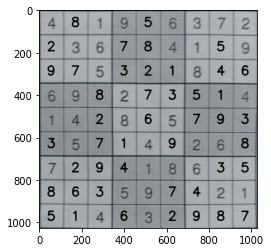

In [13]:
# Verify the sudoku solution
def check_sudoku(puzzle, solution):
  
  # Verify if initially filled elements of input changes in solution
  for i in range(81):
     if puzzle.flatten()[i] != 0:
       if puzzle.flatten()[i] != solution.flatten()[i]:
         print("Wrong solution")
         return 
        
  blocks=view_as_blocks(solution, (3, 3)).reshape(9,9)
  nos=np.arange(1,10)

  # Check uniqueness of rows, columns and blocks in solution
  for i in range(9):
    if not np.array_equal(np.unique(solution[i]), nos):
       print("Wrong solution") # rows mismatch
       return 
    elif not np.array_equal(np.unique(solution.T[i]), nos):
       print("Wrong solution") # columns mismatch
       return
    elif not np.array_equal(np.unique(blocks[i]), nos):
       print("Wrong solution") # blocks mismatch
       return 
  
  print("Correct solution")

check_sudoku(puzzle, solution)

# Plot the results over the original image
def show_output(puzzle, solution, sudoku):

  for i in range(9):
    for j in range(9):
      pos=(37+114*j, 77+114*i)
      if puzzle[i,j] == 0:
        cv2.putText(sudoku,str(solution[i,j]),pos, cv2.FONT_HERSHEY_SIMPLEX, 2, 0,5)

  plt.imshow(sudoku)

show_output(puzzle.copy(),solution.copy(),out_gry.copy())